<a href="https://colab.research.google.com/github/pdc-quantum/just-a-website/blob/master/ternary_classifier_from_binary_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# for colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, auc
from sklearn.metrics import RocCurveDisplay

In [ ]:
from scipy import stats

In [ ]:
from sklearn.preprocessing import normalize

In [ ]:
from scipy.optimize import minimize
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # not working

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

In [ ]:
from functools import reduce

In [ ]:
#!pip install mlxtend

In [ ]:
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.data import mnist_data

In [ ]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Seeding done ...")

set_seed(42)

Seeding done ...


In [ ]:
%matplotlib inline

In [ ]:
pvd = '/content/drive/MyDrive/Data/EchoNet-Dynamic/'

# Load Dataframes

In [ ]:
df_tot = pd.read_csv(pvd+"FileList.csv") #, index_col= 1)

In [ ]:
df_tot = df_tot.rename(columns={'FileName':'video'})

In [ ]:
df_tot["Duration"] = df_tot["NumberOfFrames"] / df_tot["FPS"]

In [ ]:
# new definition
df_tot['EFClass'] = np.where(
    df_tot['EF'] >= 49.5, "preserved" ,
    np.where(df_tot['EF'] < 39.5,'reduced', 'midrange') )

In [ ]:
df_tot["EFClass"].value_counts()

,count
EFClass,
preserved,7879
reduced,1229
midrange,922


In [ ]:
df_tot.head(3)

,video,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split,Duration,EFClass
0,0X100009310A3BD7FC,78.498406,14.881368,69.210534,112,112,50,174,VAL,3.48,preserved
1,0X1002E8FBACD08477,59.101988,40.383876,98.742884,112,112,50,215,TRAIN,4.30,preserved
2,0X1005D03EED19C65B,62.363798,14.267784,37.909734,112,112,50,104,TRAIN,2.08,preserved


In [ ]:
purged_df = pd.read_csv(pvd+"purged_df_train_rnr_npp.csv") #, index_col= 0)
purged_df = purged_df.rename(columns={'FileName':'video'})

In [ ]:
purged_df.head(3)

,video,EFClass
0,0X1002E8FBACD08477,preserved
1,0X1005D03EED19C65B,preserved
2,0X10075961BC11C88E,preserved


In [ ]:
purged_df["EFClass"].value_counts()

,count
EFClass,
preserved,3444
reduced,927
midrange,673


In [ ]:
df_tot_purged = df_tot[df_tot.index.isin(purged_df.index)]

In [ ]:
df_tot_purged["EFClass"].value_counts()

,count
EFClass,
preserved,3950
reduced,625
midrange,469


In [ ]:
df_npEF_BC_shuffled = pd.read_csv(pvd+"Freezer modif npp-BCEW auc fine-tune-train-movinet-A0/"+"val epoch 08.csv")


In [ ]:
df_npEF_BC_shuffled_test = pd.read_csv(pvd+"Freezer modif npp-BCEW auc fine-tune-train-movinet-A0/"+"test epoch 08.csv")

In [ ]:
df_npEF_BC_shuffled_train = pd.read_csv(pvd+"Freezer modif npp-BCEW auc fine-tune-train-movinet-A0/"+"train epoch 08.csv")


In [ ]:
df_rEF_BC_shuffled = pd.read_csv(pvd+\
  "Freezer modif rnr-BCEW auc fine-tune-train-movinet-A0/"+"val epoch 07.csv")

In [ ]:
df_rEF_BC_shuffled_test = pd.read_csv(pvd+\
  "Freezer modif rnr-BCEW auc fine-tune-train-movinet-A0/"+"test epoch 07.csv")

In [ ]:
df_rEF_BC_shuffled_train = pd.read_csv(pvd+\
  "Freezer modif rnr-BCEW auc fine-tune-train-movinet-A0/"+"train epoch 07.csv")

# Functions

In [ ]:
def plot_multi_ROC_model(name, model_dic, option = "ROC",
                         #pos_label = "reduced",
                         drop_intermediate = False, size_legend = 6):

    prop={'size': size_legend}

    plt.figure(0).clf()
    if option == "ROC":
        plt.ylabel("True Positive Rate")
        plt.xlabel("False Positive Rate")
    elif option == "PRC":
        plt.ylabel("Precision")
        plt.xlabel("Recall")
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    if option == "ROC":
        plt.plot([0,1], [0,1], 'k--')
    #plt.suptitle(suptitle)
    plt.title(name, fontsize = 10)

    for curve_name, df in model_dic.items():

        if option == "ROC":
            abs, ord, _ = roc_curve(df.label, df.prob)
            auc = roc_auc_score(df.label, df.prob)
        elif option == "PRC":
            abs, ord, _ = precision_recall_curve(df.label, df.prob, #df.true_class, df.prob,
                                                 #pos_label = pos_label,
                                                 drop_intermediate = drop_intermediate,
                                                )
            auc = average_precision_score(df.label, df.prob)
        plt.plot(abs,ord,
                 label= curve_name+" - AUC = %0.4f" % auc)
    plt.legend(loc = 0, prop=prop)
    plt.show()
    return

In [ ]:
def pAUC_aboveTPR(y_score, y_true, max_fpr):

    # using sklearn.metric functions: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(y_true, y_score, sample_weight=None)
    if max_fpr is None or max_fpr == 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr > 1:
        raise ValueError("Expected min_tpr in range [0, 1), got: %r" % min_tpr)
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    #print(tpr, fpr)
    partial_auc = auc(fpr, tpr)
    #print("partial_auc_scaled", partial_auc, "\n")
    #plt.plot(fpr,tpr,label=name + ", pAUC-aboveTPR =" + str(partial_auc))
    #plt.legend()
    #plt.show()
    return partial_auc

min_tpr = 0.80
max_fpr = abs(1-min_tpr)
threshold = 0.5

In [ ]:
def microroc(clf, X, y):
    return roc_auc_score(y,
                         clf.predict_proba(X),
                         multi_class="ovr",
                         average="micro",
    )


In [ ]:
def merge_df(df1, df2):
  if 'video' not in df1:
    df2["video"] = ""
  if 'video' not in df1:
    df1["video"] = ""

  for i in range(len(df2)):
    test_str = df2.path[i]
    res = ''.join(test_str.split("/")[9].split(".mp4"))
    df2.loc[i, "video"] = res
  df2.video[0]
  for i in range(len(df1)):
    test_str = df1.path[i]
    res = ''.join(test_str.split("/")[9].split(".mp4"))
    df1.loc[i, "video"] = res
  df1.video[0]

  merged = df1.merge(df2, on ="video")
  merged = merged.drop(["path_x","path_y"], axis = 1)
  return merged

In [ ]:
def merge_df_list(data_frames) : #, split=".mp4"):
  for df in data_frames:
   if 'video' not in df:
    df["video"] = ""
    for i in range(len(df)):
      test_str = df.path[i]
      res = ''.join(test_str.split("/")[9].split(".mp4"))
      df.loc[i, "video"] = res

  merged = reduce(lambda  left,right: pd.merge(left,right,on=['video'],
                                             how='outer'), data_frames)


  #merged = merged.drop(["path_x","path_y", "path"], axis = 1)
  return merged

In [ ]:
def plot_confusion_matrix(model, df, labels, display_labels):
    cm = confusion_matrix(df.true_class, df.pred_class, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels,
                                 )
    print(model)
    disp.plot()
    plt.show()

In [ ]:
def myfunc(pred_x, pred_y):
  if pred_x == 1 and pred_y == 0:
    t_class = "preserved"
  elif pred_x == 1 and pred_y == 1:
    t_class = "midrange"
  elif pred_x == 0 and pred_y == 0:
    t_class = "midrange"
  elif pred_x == 0 and pred_y == 1:
    t_class = "reduced"
  return t_class

In [ ]:
def myfunc_np_vs_p(pred_x, pred_y): # not used so far here
  if pred_x == 1 and pred_y == 0:
    t_class = "is preserved"
  elif pred_x == 1 and pred_y == 1:
    t_class = "not preserved"
  elif pred_x == 0 and pred_y == 0:
    t_class = "not preserved"
  elif pred_x == 0 and pred_y == 1:
    t_class = "not preserved"
  return t_class

In [ ]:
def myfunc_r_vs_nr(pred_x, pred_y): # not used so far here
  if pred_x == 1 and pred_y == 0:
    t_class = "not reduced"
  elif pred_x == 1 and pred_y == 1:
    t_class = "not reduced"
  elif pred_x == 0 and pred_y == 0:
    t_class = "not reduced"
  elif pred_x == 0 and pred_y == 1:
    t_class = "reduced"
  return t_class

In [ ]:
def myfunc_prob(pef, ref, threshold_1 = 0.5, threshold_2 = 0.5,
                threshold_3 = 0.5, threshold_4 = 0.5):

  if pef >= 0.5 and ref < 0.5:
    if pef >=  threshold_1:
      t_class = "preserved"
    else:
      t_class = "midrange"

  elif pef < 0.5 and ref >= 0.5:
    if ref >=  threshold_2:
      t_class = "reduced"
    else:
      t_class = "midrange"

  elif pef < 0.5 and ref < 0.5:
    if pef-ref >= threshold_3 :
      t_class = "preserved"
    elif ref-pef >= threshold_3 :
      t_class = "reduced"
    else:
      t_class = "midrange"


  elif pef >= 0.5 and ref >= 0.5:
    if pef-ref >= threshold_4 :
      t_class = "preserved"
    elif ref-pef >= threshold_4 :
      t_class = "reduced"
    else:
      t_class = "midrange"

  return t_class

In [ ]:
def evaluate(model, X_train, X_val, X_test, y_train, y_val, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    print("TRAINIG RESULTS: \n")
    print(classification_report(y_train, y_train_pred)) #, output_dict=True))
    print()
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_train, y_train_pred):.4f}")
    print()
    print("VALIDATION RESULTS: \n")
    print(classification_report(y_val, y_val_pred))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_val, y_val_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_val, y_val_pred):.4f}")
    print()
    print("TESTING RESULTS: \n")
    print(classification_report(y_test, y_test_pred))
    print(f"CONFUSION MATRIX:\n{confusion_matrix(y_test, y_test_pred)}")
    print(f"ACCURACY SCORE:\n{accuracy_score(y_test, y_test_pred):.4f}")

# Data

## All Data

In [ ]:
df_tot.head(3).transpose()

,0,1,2
video,0X100009310A3BD7FC,0X1002E8FBACD08477,0X1005D03EED19C65B
EF,78.498406,59.101988,62.363798
ESV,14.881368,40.383876,14.267784
EDV,69.210534,98.742884,37.909734
FrameHeight,112,112,112
FrameWidth,112,112,112
FPS,50,50,50
NumberOfFrames,174,215,104
Split,VAL,TRAIN,TRAIN
Duration,3.48,4.3,2.08


In [ ]:
df_tot["EFClass"].value_counts()

,count
EFClass,
preserved,7879
reduced,1229
midrange,922


## Train data

In [ ]:
merged_7465 = merge_df_list([df_npEF_BC_shuffled_train, df_rEF_BC_shuffled_train])

In [ ]:
merged_7465 = merged_7465.drop(["path_x","path_y"], axis = 1)

In [ ]:
merged_7465.head(1)

,true_class_x,pred_class_x,label_x,pred_x,prob_x,video,true_class_y,pred_class_y,label_y,pred_y,prob_y
0,is preserved,is preserved,0.0,0.0,0.005358,0X1002E8FBACD08477,not reduced,not reduced,0.0,0.0,0.001199


In [ ]:
col_rename = {"true_class_x": "true_class_npp",
              "pred_class_x": "pred_class_npp",
              "label_x": "label_npp",
              "pred_x": "pred_npp",
              "prob_x": "prob_npp",
              "true_class_y": "true_class_rnr",
              "pred_class_y": "pred_class_rnr",
              "label_y": "label_rnr",
              "pred_y": "pred_rnr",
              "prob_y": "prob_rnr",
              }
merged_7465.rename(columns = col_rename, inplace = True)

### Here a change:

In [ ]:
df_train = df_tot.query(' Split == "TRAIN" ')[['video', "EF", "EFClass"]]
df_train.rename(columns ={"EFClass": "true_class"}, inplace = True)
merged_7465 = merged_7465.merge(df_train, on = "video")

In [ ]:
merged_7465['pred_class'] = merged_7465.apply(lambda x: myfunc(1-x['pred_npp'], x['pred_rnr']), axis=1)

In [ ]:
merged_7465.head(3).T

,0,1,2
true_class_npp,is preserved,is preserved,is preserved
pred_class_npp,is preserved,is preserved,is preserved
label_npp,0.0,0.0,0.0
pred_npp,0.0,0.0,0.0
prob_npp,0.005358,0.435496,0.002491
video,0X1002E8FBACD08477,0X1005D03EED19C65B,0X10075961BC11C88E
true_class_rnr,not reduced,not reduced,not reduced
pred_class_rnr,not reduced,not reduced,not reduced
label_rnr,0.0,0.0,0.0
pred_rnr,0.0,0.0,0.0


### Summary

In [ ]:
merged_7465["label"] = np.where(merged_7465["true_class"] == "preserved", 0, np.where(merged_7465["true_class"] == "midrange", 1,2))

### Purge: use only train items not used previouly in the binary classifiers

In [ ]:
merged_7465 = merged_7465[merged_7465.index.isin(purged_df.index)]

In [ ]:
merged_7465[["pred_class"]].value_counts()

,count
pred_class,
preserved,3415
reduced,913
midrange,716


## Val data

In [ ]:
merged = merge_df_list([df_npEF_BC_shuffled, df_rEF_BC_shuffled])

In [ ]:
merged = merged.drop(["path_x","path_y"], axis = 1)

In [ ]:
col_rename = {"true_class_x": "true_class_npp",
              "pred_class_x": "pred_class_npp",
              "label_x": "label_npp",
              "pred_x": "pred_npp",
              "prob_x": "prob_npp",
              "true_class_y": "true_class_rnr",
              "pred_class_y": "pred_class_rnr",
              "label_y": "label_rnr",
              "pred_y": "pred_rnr",
              "prob_y": "prob_rnr",
}
merged.rename(columns = col_rename, inplace = True)

In [ ]:
df_val = df_tot.query(' Split == "VAL" ')[['video', "EF", "EFClass"]]
df_val.rename(columns ={"EFClass": "true_class"}, inplace = True)
merged = merged.merge(df_val, on = "video")

In [ ]:
merged['pred_class'] = merged.apply(lambda x: myfunc(1-x['pred_npp'], x['pred_rnr']), axis=1)

In [ ]:
merged["label"] = np.where(merged["true_class"] == "preserved", 0, np.where(merged["true_class"] == "midrange", 1,2))

## Test data

In [ ]:
merged_t = merge_df_list([df_npEF_BC_shuffled_test, df_rEF_BC_shuffled_test])

In [ ]:
merged_t = merged_t.drop(["path_x","path_y"], axis = 1)

In [ ]:
col_rename = {"true_class_x": "true_class_npp",
              "pred_class_x": "pred_class_npp",
              "label_x": "label_npp",
              "pred_x": "pred_npp",
              "prob_x": "prob_npp",
              "true_class_y": "true_class_rnr",
              "pred_class_y": "pred_class_rnr",
              "label_y": "label_rnr",
              "pred_y": "pred_rnr",
              "prob_y": "prob_rnr",
}
merged_t.rename(columns = col_rename, inplace = True)

In [ ]:
df_test = df_tot.query(' Split == "TEST" ')[['video', "EF", "EFClass"]]
df_test.rename(columns ={"EFClass": "true_class"}, inplace = True)
merged_t = merged_t.merge(df_test, on = "video")

In [ ]:
merged_t['pred_class'] = merged_t.apply(lambda x: myfunc(1-x['pred_npp'], x['pred_rnr']), axis=1)

In [ ]:
merged_t["label"] = np.where(merged_t["true_class"] == "preserved", 0, np.where(merged_t["true_class"] == "midrange", 1,2))

# Single Classifiers

In [ ]:
# feature matrix for fit
prob_features = "npp rnr"
df_list = [merged_7465, merged, merged_t]
for df_last in df_list:
  if prob_features == "npp rnr":
    df_last["probs"] = df_last[['prob_npp', 'prob_rnr']].values.tolist()
    df_last["preds"] = df_last[['pred_npp', 'pred_rnr']].values.tolist()
  elif prob_features == "npp rnr correl":
    df_last['correl_probs'] = df_last.prob_npp * df_last.prob_rnr
    df_last["probs"] = df_last[['prob_npp', 'prob_rnr', 'correl_probs']].values.tolist()
    df_last["preds"] = df_last[['pred_npp', 'pred_rnr']].values.tolist()
  elif prob_features == "npp rnr rp":
    df_last["probs"] = df_last[['prob_npp', 'prob_rnr','prob_rp']].values.tolist()
    df_last["preds"] = df_last[['pred_npp', 'pred_rnr','pred_rp']].values.tolist()
  elif prob_features == "npp rnr mnm":
    df_last["probs"] = df_last[['prob_npp', 'prob_rnr','prob_mnm']].values.tolist()
    df_last["preds"] = df_last[['pred_npp', 'pred_rnr','pred_mnm']].values.tolist()
  elif prob_features == "npp rnr mnm rp":
    df_last["probs"] = df_last[['prob_npp', 'prob_rnr','prob_mnm','prob_rp']].values.tolist()
    df_last["preds"] = df_last[['pred_npp', 'pred_rnr','pred_mnm','prob_rp']].values.tolist()
  elif prob_features == "rnr":
    df_last["probs"] = df_last[['prob_rnr']].values.tolist()
    df_last["preds"] = df_last[['pred_rnr']].values.tolist()


In [ ]:
import matplotlib.gridspec as gridspec
import itertools
from mlxtend.plotting import plot_decision_regions # not used

In [ ]:
from sklearn.neighbors import KNeighborsClassifier ,RadiusNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB, ComplementNB, BernoulliNB, MultinomialNB

In [ ]:
priors = [1/6,2/6,3/6]
class_weight= dict(zip([0,1,2],priors))
priors = 3*[1/3]
class_weight = "balanced"
print(class_weight)
var_smoothing=1e-02 # minimally worse
var_smoothing=1e-12 # no effect
var_smoothing=1e-04 # minimally worse
var_smoothing=1e-06 # no effect
var_smoothing=1e-09 # default, seems ok
lrg = LogisticRegression(solver= 'lbfgs', #'newton-cg' was sligthly worse
                         class_weight= class_weight,
                         fit_intercept = True,
                         random_state = 42)
gnb = GaussianNB(priors = priors,
                 var_smoothing=var_smoothing
                 )
rfc = RandomForestClassifier(class_weight= class_weight,
                             random_state = 42)
# no advantage to add rfc: rnr sensitivity <.85 and slightly worse
sgdc = SGDClassifier(random_state=42,
                     class_weight= class_weight,
                     loss = "modified_huber") # "log_loss")
# no advantage to add sgdc: rnr sensitivity <.85 and slightly worse
dtc = DecisionTreeClassifier(class_weight= class_weight,
                             random_state = 42)

balanced


In [ ]:
X_val = np.array(merged["probs"].array.tolist()) # took a time to find the workaround
y_val = merged["label"].to_numpy()
X_test = np.array(merged_t["probs"].array.tolist()) # took a time to find the workaround
y_test = merged_t["label"].to_numpy()
X_train = np.array(merged_7465["probs"].array.tolist()) # X_val.copy() #
y_train = merged_7465["label"].to_numpy() # y_val.copy() #

In [ ]:
clfs_one = []
clfs_one.append(lrg)
clfs_one.append(rfc)
clfs_one.append(gnb)
clfs_one.append(dtc)
#clfs_one.append(SVC(gamma='scale')) # not uses: has not predict_proba
clfs_one.append(sgdc)
clfs_one.append(KNeighborsClassifier())
#clfs_one.append(CategoricalNB())

clfs_labels = ['Logistic Regression, lbfgs',
               'RandomForestClassifier',
               'GaussianNB',
               'DecisionTree',
               'SGDClassifier',
               'KNeighborsClassifier',
                #'MultinomialNB' #BernoulliNB'#'ComplementNB', # CategoricalNB : all bad
              ]

nb_classifiers = len(clfs_one)
rounding = 5


In [ ]:
# here for merged_t
clfs_dic = {}
for clf, lab in zip(clfs_one, clfs_labels):
    clf.fit(X_train, y_train)

    print("CLASSIFIER "+ lab + " " +prob_features + " (validation)")
    print()
    evaluate(clf, X_train, X_val, X_test, y_train, y_val, y_test)
    print()
    merged_t["reprob_npp"] = 1. - clf.predict_proba(X_test)[:, 0]
    merged_t["reprob_rnr"] = clf.predict_proba(X_test)[:, 2]
    #merged_t["repred_npp"] = np.round(1. - eclf.predict_proba(X_val))
    #merged_t["repred_rnr"] = eclf.predict(X_val)[:, 2]
    print("npp")
    #print("accuracy_score",round(accuracy_score(merged_t.label_npp, merged_t.repred_npp.item()),rounding))
    print("roc_auc_score",round(roc_auc_score(merged_t.label_npp, merged_t.reprob_npp).item(),rounding))
    print("pAUC_aboveTPR",round(pAUC_aboveTPR(merged_t.reprob_npp,merged_t.label_npp, max_fpr).item(),rounding))
    print("average_precision_score",round(average_precision_score(merged_t.label_npp, merged_t.reprob_npp).item(),rounding))
    print("rnr")
    print("roc_auc_score",round(roc_auc_score(merged_t.label_rnr, merged_t.reprob_rnr).item(),rounding))
    print("pAUC_aboveTPR",round(pAUC_aboveTPR(merged_t.reprob_rnr, merged_t.label_rnr, max_fpr).item(),rounding))
    print("average_precision_score",round(average_precision_score(merged_t.label_rnr, merged_t.reprob_rnr).item(),rounding))
    print()

    clfs_dic[lab] = microroc(clf, X_val, y_val)
    #clfs_dic[lab] = roc_auc_score(merged_t.label_npp, merged_t.reprob_npp).item()

print(prob_features)
print("microroc")
sorted_clfs_rnr = (sorted(clfs_dic.items(), key=lambda x:x[1], reverse = True))
for i, auc_result in enumerate(sorted_clfs_rnr):
  print(i, auc_result )



CLASSIFIER Logistic Regression, lbfgs npp rnr (validation)

TRAINIG RESULTS: 

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      3952
           1       0.50      0.72      0.59       458
           2       0.78      0.94      0.85       634

    accuracy                           0.90      5044
   macro avg       0.76      0.86      0.80      5044
weighted avg       0.92      0.90      0.91      5044


CONFUSION MATRIX:
[[3595  297   60]
 [  21  330  107]
 [   3   33  598]]
ACCURACY SCORE:
0.8967

VALIDATION RESULTS: 

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1012
           1       0.28      0.43      0.34       125
           2       0.69      0.79      0.73       151

    accuracy                           0.82      1288
   macro avg       0.64      0.70      0.66      1288
weighted avg       0.86      0.82      0.84      1288

CONFUSION MATRIX:
[[885 110  17]
 [ 34 

# Optimizing EnsembleVoteClassifier Weights with scipy.optimize minimize

In [ ]:
score_opt = "micro_roc_auc"

def function_to_minimize(weights, fitted_clfs):

    #w1, w2, w3 = weights  # these are the new weights!
    new_w = np.append(weights, 1.0) # MODIFIED

    newclf = EnsembleVoteClassifier(
        voting=voting_method,
        use_clones=False,
        fit_base_estimators=False,
        clfs=fitted_clfs,
        weights= new_w.tolist() , #tnew_w.all() #
    )

    newclf.fit(X_train, y_train)

    if score_opt == "accuracy_score":
      score = newclf.score(X_val, y_val)

    elif score_opt =="roc_auc_npp":
      score = roc_auc_score(y_val_npp, 1. - newclf.predict_proba(X_val)[:, 0])

    elif score_opt =="roc_auc_rnr":
      score = roc_auc_score(y_val_rnr, newclf.predict_proba(X_val)[:, 2])

    elif score_opt == "micro_roc_auc":
      score = microroc(newclf, X_val, y_val)

    return 1 - score

In [ ]:
clfs = []
#clfs.append(rfc)
#clfs.append(sgdc)
#clfs.append(gnb)
clfs.append(gnb)#
clfs.append(lrg)
#clfs.append(KNeighborsClassifier(n_neighbors=5, p= 1) )
#clfs.append(CategoricalNB(alpha=0)) # alternative ‘loss_log similar as lr
#clfs.append(DecisionTreeClassifier())

# not used from here
# note:  = "distance" worse p=1 better n_neighbors=5 is optimal
#clfs.append(Categ#oricalNB(alpha=0)) # fit_prior=False: worse alpha = 0 better
#clfs.append(RadiusNeighborsClassifier()) # poor  (with p = 1 or 2)
#clfs.append(SVC(gamma='scale')) # not uses: has not predict_proba

nb_classifiers = len(clfs)
voting_method = "soft"
minimize_method = 'Powell' #'BFGS' # 'Nelder-Mead'
number_weights = nb_classifiers - 1
bounds = tuple((number_weights)*[(0.,50.0)])

In [ ]:
for clf in clfs:
  clf.fit(X_train, y_train)

In [ ]:
if nb_classifiers > 1:
  eclf = EnsembleVoteClassifier(
    clfs=clfs,
    voting=voting_method,  # the same would also work with "hard" voting
    weights=tuple(nb_classifiers*[1]),
    use_clones=False,
    fit_base_estimators=False,
)

In [ ]:
%%capture --no-display
if nb_classifiers > 1:
  y_val_npp = np.where(y_val == 0, 0, 1)
  y_val_rnr = np.where(y_val == 2, 1, 0)
  init_weights = number_weights*[1.0] # working #was: init_weights = [1., 1.]

  results = minimize(
      function_to_minimize,
      init_weights,
      args=(clfs),
      bounds = bounds, # no bounds is better?
      method=minimize_method,
  )

In [ ]:
if nb_classifiers > 1:
  solution = []
  for result in results["x"]:
    solution.append(result)
  solution.append(1.0) # MODIFIED
  print(solution)

[49.612194974390384, 1.0]


In [ ]:
if nb_classifiers > 1:
  eclf = EnsembleVoteClassifier(
    clfs=clfs,
    voting=voting_method,  # the same would also work with "hard" voting
    weights=solution, # tuple(nb_classifiers*[1]),
    use_clones=False,
    fit_base_estimators=False,
    verbose = 2,
)

else:
  eclf = clfs[0]
eclf.fit(X_train, y_train)
print("train:", eclf.score(X_train, y_train))
print(" val:", eclf.score(X_val, y_val))
print("test:", eclf.score(X_test, y_test))

train: 0.8996827914353688
 val: 0.8291925465838509
test: 0.8339859044635866


In [ ]:
print("microroc")
print("train:", microroc(eclf, X_train, y_train))
print(" val:", microroc(eclf, X_val, y_val))
print("test:", microroc(eclf, X_test, y_test))


microroc
train: 0.9813411801680503
 val: 0.9558749421318622
test: 0.9527085738954786


## Post voting: Test metrics

In [ ]:
print("features "+prob_features+" -  score is "+ score_opt)
if len(clfs) > 1:
  print(eclf)
  print("bounds:", bounds, "minimize method:", minimize_method)
  print("weights:", solution)
elif nb_classifiers == 1:
  eclf= clfs[0]
  print("classifier unique:", eclf)
evaluate(eclf, X_train, X_val, X_test, y_train, y_val, y_test)
print()
print("VALIDATION")
merged["reprob_npp"] = 1. - eclf.predict_proba(X_val)[:, 0]
merged["reprob_rnr"] = eclf.predict_proba(X_val)[:, 2]
#merged["repred_npp"] = np.round(1. - eclf.predict_proba(X_val))
#merged["repred_rnr"] = eclf.predict(X_val)[:, 2]
print("npp")
#print("accuracy_score",round(accuracy_score(merged.label_npp, merged.repred_npp.item()),rounding))
print("roc_auc_score",round(roc_auc_score(merged.label_npp, merged.reprob_npp).item(),rounding))
print("pAUC_aboveTPR",round(pAUC_aboveTPR(merged.reprob_npp,merged.label_npp, max_fpr).item(),rounding))
print("average_precision_score",round(average_precision_score(merged.label_npp, merged.reprob_npp).item(),rounding))
print("rnr")
print("roc_auc_score",round(roc_auc_score(merged.label_rnr, merged.reprob_rnr).item(),rounding))
print("pAUC_aboveTPR",round(pAUC_aboveTPR(merged.reprob_rnr, merged.label_rnr, max_fpr).item(),rounding))
print("average_precision_score",round(average_precision_score(merged.label_rnr, merged.reprob_rnr).item(),rounding))
print()
print("TEST")
merged_t["reprob_npp"] = 1. - eclf.predict_proba(X_test)[:, 0]
merged_t["reprob_rnr"] = eclf.predict_proba(X_test)[:, 2]
#merged_t["repred_npp"] = np.round(1. - eclf.predict_proba(X_test))
#merged_t["repred_rnr"] = eclf.predict(X_test)[:, 2]
print("npp")
#print("accuracy_score",round(accuracy_score(merged_t.label_npp, merged_t.repred_npp.item()),rounding))
print("roc_auc_score",round(roc_auc_score(merged_t.label_npp, merged_t.reprob_npp).item(),rounding))
print("pAUC_aboveTPR",round(pAUC_aboveTPR(merged_t.reprob_npp,merged_t.label_npp, max_fpr).item(),rounding))
print("average_precision_score",round(average_precision_score(merged_t.label_npp, merged_t.reprob_npp).item(),rounding))
print("rnr")
print("roc_auc_score",round(roc_auc_score(merged_t.label_rnr, merged_t.reprob_rnr).item(),rounding))
print("pAUC_aboveTPR",round(pAUC_aboveTPR(merged_t.reprob_rnr, merged_t.label_rnr, max_fpr).item(),rounding))
print("average_precision_score",round(average_precision_score(merged_t.label_rnr, merged_t.reprob_rnr).item(),rounding))
print()

print("microroc")
print("train:", microroc(eclf, X_train, y_train))
print(" val:", microroc(eclf, X_val, y_val))
print("test:", microroc(eclf, X_test, y_test))


features npp rnr -  score is micro_roc_auc
EnsembleVoteClassifier(clfs=[GaussianNB(priors=[0.3333333333333333,
                                                0.3333333333333333,
                                                0.3333333333333333]),
                             LogisticRegression(class_weight='balanced',
                                                random_state=42)],
                       fit_base_estimators=False, use_clones=False, verbose=2,
                       voting='soft', weights=[49.612194974390384, 1.0])
bounds: ((0.0, 50.0),) minimize method: Powell
weights: [49.612194974390384, 1.0]
TRAINIG RESULTS: 

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      3952
           1       0.50      0.70      0.59       458
           2       0.78      0.95      0.86       634

    accuracy                           0.90      5044
   macro avg       0.76      0.86      0.80      5044
weighted avg       0.92      0.9

### Post voting: Test metrics

In [ ]:
eclf.predict_proba(X_test)[1]

array([3.02869237e-04, 3.12353964e-02, 9.68461734e-01])

In [ ]:
merged_t["reprob_npp"] = 1. - eclf.predict_proba(X_test)[:, 0]
merged_t["reprob_rnr"] = eclf.predict_proba(X_test)[:, 2]

In [ ]:
npp_final = merged_t[[ 'true_class_npp', 'label_npp', 'reprob_npp', 'video' ]].copy()
npp_final.rename(columns={'true_class_npp': 'true_class', 'label_npp': 'label', 'reprob_npp': 'prob'}, inplace=True)
npp_final['pred'] = np.where(np.argmax(eclf.predict_proba(X_test), axis=1) != 0, 1.0, 0.0)
npp_final['pred_class'] = np.where(npp_final['pred'] == 0.0, 'is preserved', 'not preserved')

In [ ]:
npp_final[["true_class", "pred_class"]].value_counts()

,,count
true_class,pred_class,
is preserved,is preserved,891
not preserved,not preserved,222
is preserved,not preserved,111
not preserved,is preserved,53


In [ ]:
rnr_final = merged_t[[ 'true_class_rnr', 'label_rnr', 'reprob_rnr', 'video' ]].copy()
rnr_final.rename(columns={'true_class_rnr': 'true_class', 'label_rnr': 'label', 'reprob_rnr': 'prob'}, inplace=True)
rnr_final['pred'] = np.where(np.argmax(eclf.predict_proba(X_test), axis=1) == 2, 1.0, 0.0)
rnr_final['pred_class'] = np.where(rnr_final['pred'] == 1.0, 'reduced', 'not reduced')

In [ ]:
rnr_final[["true_class", "pred_class"]].value_counts()

,,count
true_class,pred_class,
not reduced,not reduced,1082
reduced,reduced,123
not reduced,reduced,44
reduced,not reduced,28


# Metric Summary

In [ ]:
model_dic = {
    "rEF vs nrEF, genuine": df_rEF_BC_shuffled_test,
    "rEF vs nrEF, ensemble": rnr_final,
    "npEF vs pEF, genuine": df_npEF_BC_shuffled_test,
    "npEF vs pEF, ensemble": npp_final
}

In [ ]:
model_dic_reduced_ef = {
    "rEF vs nrEF, genuine": df_rEF_BC_shuffled_test,
     "rEF vs nrEF, ensemble": rnr_final
}

In [ ]:
model_dic_npef = {
   "npEF vs pEF, genuine": df_npEF_BC_shuffled_test,
   "npEF vs pEF, ensemble": npp_final
}

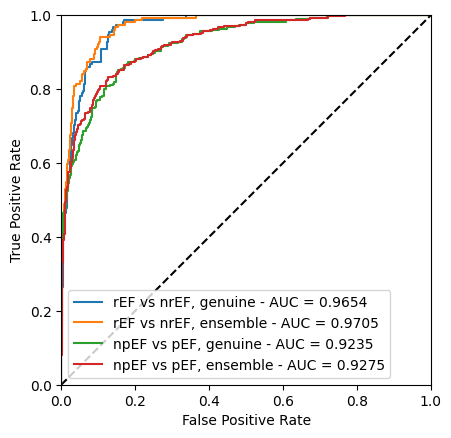

In [ ]:
plot_multi_ROC_model(None, model_dic, size_legend = 10 )

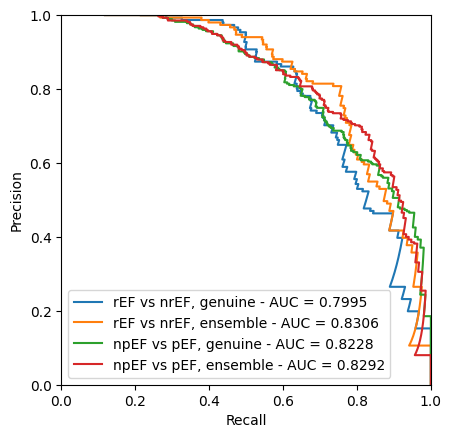

In [ ]:
plot_multi_ROC_model(None, model_dic, size_legend = 10, option = "PRC")

In [ ]:
roc_auc_list = []
pauc_above_list = []
pr_auc_list = []
acc_list = []
bacc_list = []
p0_list = []
r0_list = []
f0_list = []
p1_list = []
r1_list = []
f1_list = []
index_m =[]
for model, df in model_dic.items():
    roc_auc_m = roc_auc_score(df.label, df.prob)
    acc_m = accuracy_score(df.label, df.pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(df.label, df.pred)
    pr_auc_m = average_precision_score(df.label, df.prob)
    pAUC = pAUC_aboveTPR(df.prob, df.label, max_fpr)

    roc_auc_list.append(roc_auc_m)
    pauc_above_list.append(pAUC)
    pr_auc_list.append(pr_auc_m)
    acc_list.append(acc_m)
    bacc_list.append(np.mean(recall)) # CORRECT HERE AROUND!
    p0_list.append(precision[0])
    r0_list.append(recall[0])
    f0_list.append(fscore[0])
    p1_list.append(precision[1])
    r1_list.append(recall[1])
    f1_list.append(fscore[1])
    index_m.append(model)

In [ ]:
df_m = pd.DataFrame(acc_list, index = index_m, columns = ['Accuracy'])
df_m['Balanced accuracy'] = bacc_list
df_m['ROC AUC'] =  roc_auc_list
df_m['pAUC above 80% tpr'] =  pauc_above_list
df_m['PR AUC'] =  pr_auc_list
df_m['Precision 1'] = p1_list
df_m['Recall 1 (sensitivity)'] = r1_list
df_m['F1 score 1'] = f1_list
df_m['Precision 0'] = p0_list
df_m['Recall 0 (specificity)'] = r0_list
df_m['F1 Score 0'] = f0_list

df_m.transpose().round(3)

,"rEF vs nrEF, genuine","rEF vs nrEF, ensemble","npEF vs pEF, genuine","npEF vs pEF, ensemble"
Accuracy,0.886,0.944,0.850,0.872
Balanced accuracy,0.895,0.888,0.837,0.848
ROC AUC,0.965,0.971,0.923,0.927
pAUC above 80% tpr,0.167,0.172,0.146,0.149
PR AUC,0.799,0.831,0.823,0.829
Precision 1,0.511,0.737,0.614,0.667
Recall 1 (sensitivity),0.907,0.815,0.815,0.807
F1 score 1,0.654,0.774,0.700,0.730
Precision 0,0.986,0.975,0.944,0.944
Recall 0 (specificity),0.884,0.961,0.859,0.889


In [ ]:
def plot_confusion_matrix(model, df, labels, display_labels):
    cm = confusion_matrix(df.true_class, df.pred_class, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels,
                                 )
    print(model)
    disp.plot()
    plt.show()

npEF vs pEF, genuine


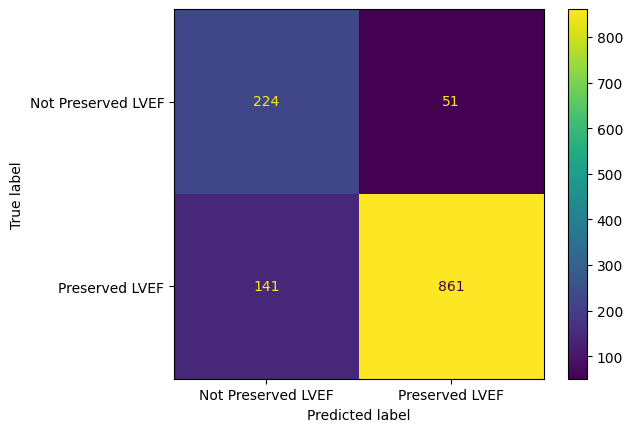

npEF vs pEF, ensemble


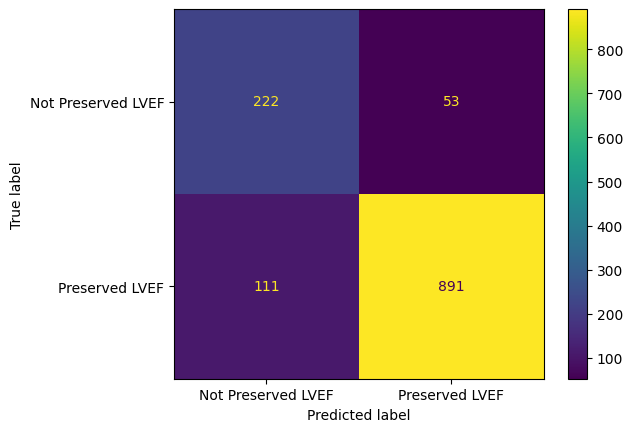

In [ ]:
for model, df in model_dic_npef.items():
     plot_confusion_matrix(model, df, labels=['not preserved','is preserved'],
                          display_labels=['Not Preserved LVEF','Preserved LVEF']
                          )

rEF vs nrEF, genuine


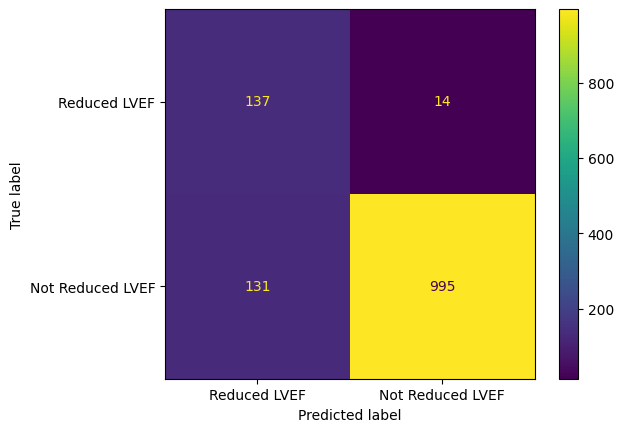

rEF vs nrEF, ensemble


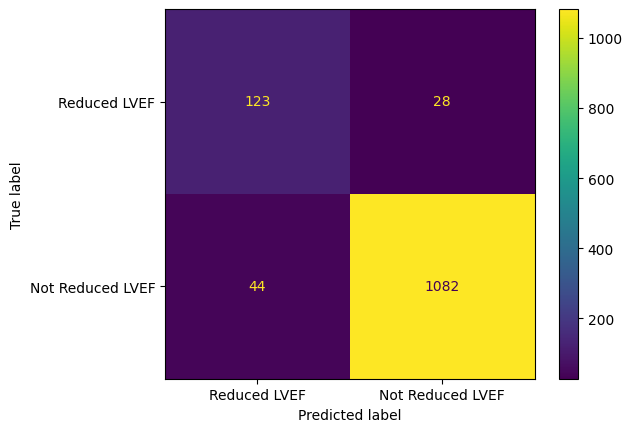

In [ ]:
for model, df in model_dic_reduced_ef.items():
     plot_confusion_matrix(model, df, labels=['reduced','not reduced'],
                          display_labels=['Reduced LVEF','Not Reduced LVEF']
                          )

# Multiclass Receiver Operating Characteristic (ROC)
[Reference in SKlearn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py)

In [ ]:
y_score = eclf.predict_proba(X_test)

In [ ]:
merged_t[["label","true_class" ]].value_counts()

,,count
label,true_class,
0,preserved,1002
2,reduced,151
1,midrange,124


In [ ]:
n_classes = len(np.unique(y_train))
n_classes

3

In [ ]:
target_names = ["preserved EF",'midrange EF', 'reduced EF']
toggle = ["not ", "", ""]
color_choice = ["cyan", "orange", "magenta"]

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(1277, 3)

In [ ]:
label_binarizer.transform([2])

array([[0, 0, 1]])

In [ ]:
class_of_interest = 2
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

2

In [ ]:
def display_one_vs_rest(class_id):
  prob_d  = y_score[:, class_id]
  label_d = y_onehot_test[:, class_id]
  title="One-vs-Rest ROC curves:\n"+target_names[class_id]\
      + " vs the rest"

  if toggle[class_id] == "not ":
    prob_d  = 1.0 - prob_d
    label_d = 1 - label_d
    title="One-vs-Rest ROC curves:\n"+toggle[class_id]+target_names[class_id]\
      + " vs "+ target_names[class_id]

  display = RocCurveDisplay.from_predictions(
      label_d, #y_onehot_test[:, class_id],
      prob_d, #y_score[:, class_id],
      name=toggle[class_id]+target_names[class_id]+ " vs the rest",
      color=color_choice[class_id],
      plot_chance_level=True,
  )
  _ = display.ax_.set(
      xlabel="False Positive Rate",
      ylabel="True Positive Rate",
      title=title
  )

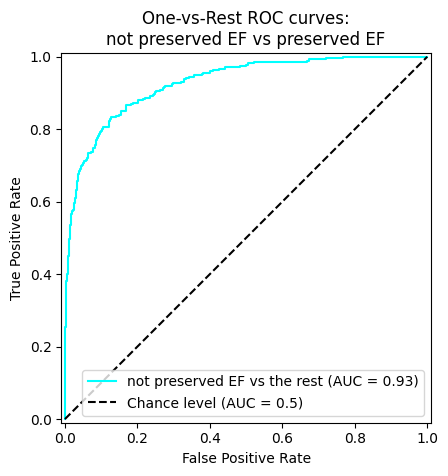

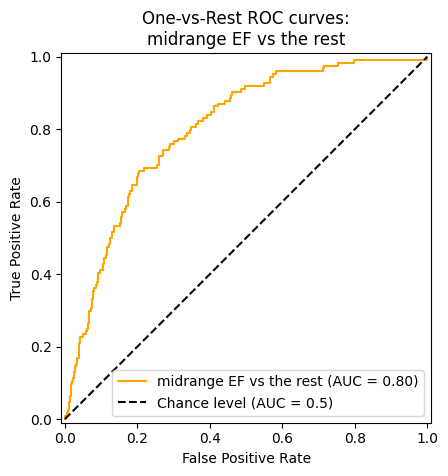

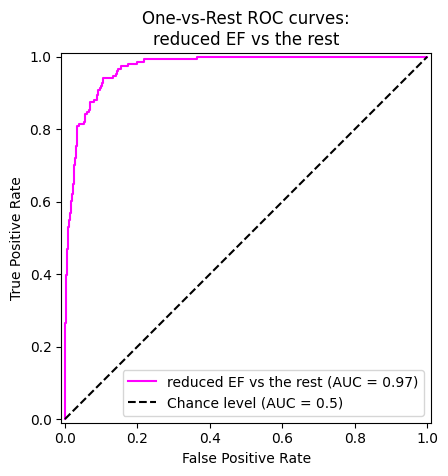

In [ ]:
for class_id in range(n_classes):
  display_one_vs_rest(class_id)

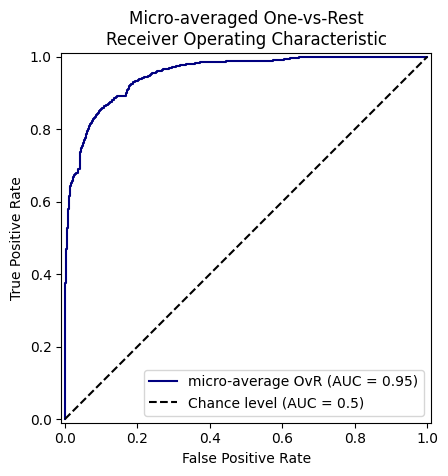

In [ ]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="navy",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [ ]:
from sklearn.metrics import roc_auc_score

micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr:.4f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.9527


In [ ]:
from sklearn.metrics import auc, roc_curve

# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.4f}")

Micro-averaged One-vs-Rest ROC AUC score:
0.9527


In [ ]:
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.90


In [ ]:
macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.90


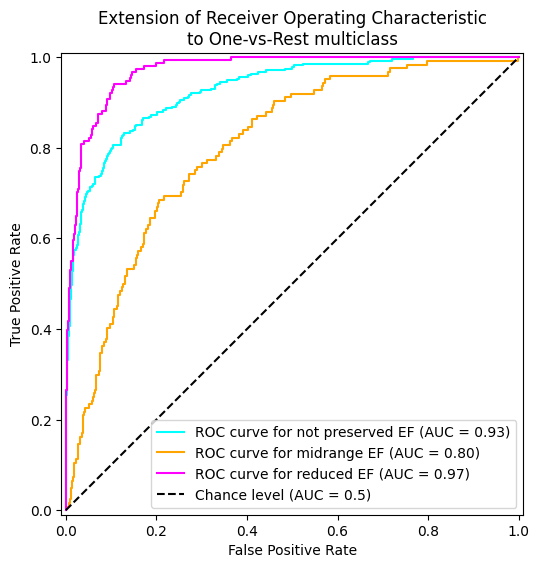

In [ ]:
# In a multi-class classification setup with highly imbalanced classes,
# micro-averaging is preferable over macro-averaging.

from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

for class_id, color in zip(range(n_classes), color_choice):

    prob_d  = y_score[:, class_id]
    label_d = y_onehot_test[:, class_id]

    if toggle[class_id] == "not ":
      prob_d  = 1.0 - prob_d
      label_d = 1 - label_d

    RocCurveDisplay.from_predictions(
        label_d, #y_onehot_test[:, class_id],
        prob_d, #y_score[:, class_id],
        name="ROC curve for "+toggle[class_id]+target_names[class_id],
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

    name=toggle[class_id]+target_names[class_id]+ " vs the rest",

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

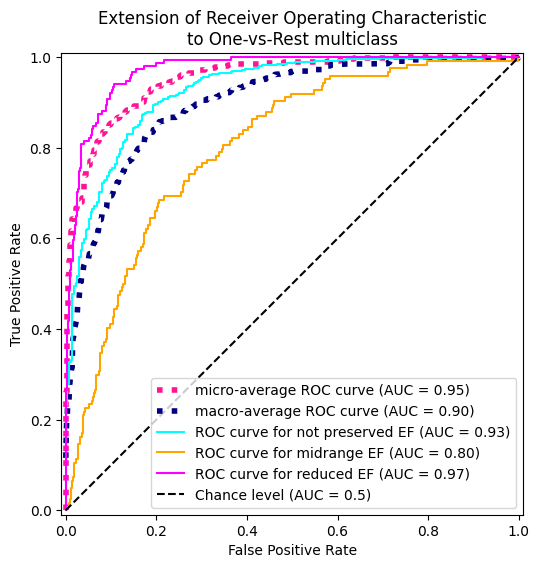

In [ ]:
# In a multi-class classification setup with highly imbalanced classes,
# micro-averaging is preferable over macro-averaging.

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

for class_id, color in zip(range(n_classes), color_choice):

    prob_d  = y_score[:, class_id]
    label_d = y_onehot_test[:, class_id]

    if toggle[class_id] == "not ":
      prob_d  = 1.0 - prob_d
      label_d = 1 - label_d

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name="ROC curve for "+toggle[class_id]+target_names[class_id],
        color=color,
        ax=ax,
        plot_chance_level=(class_id == 2),
    )

    name=toggle[class_id]+target_names[class_id]+ " vs the rest",

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

## ROC curve using the OvO macro-average

In [ ]:
from itertools import combinations

pair_list = list(combinations(np.unique(y_train), 2))
print(pair_list)

[(0, 1), (0, 2), (1, 2)]


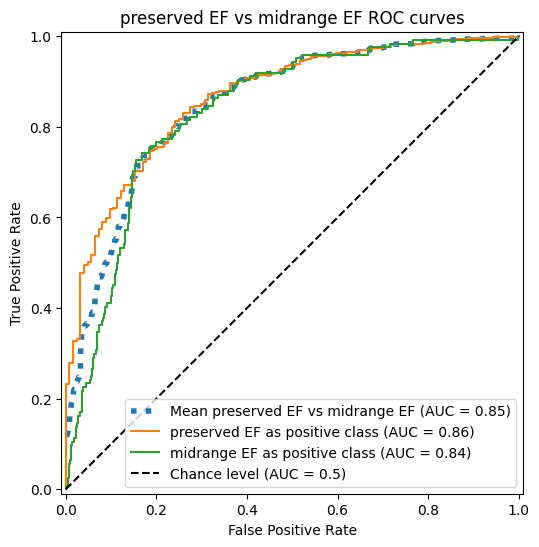

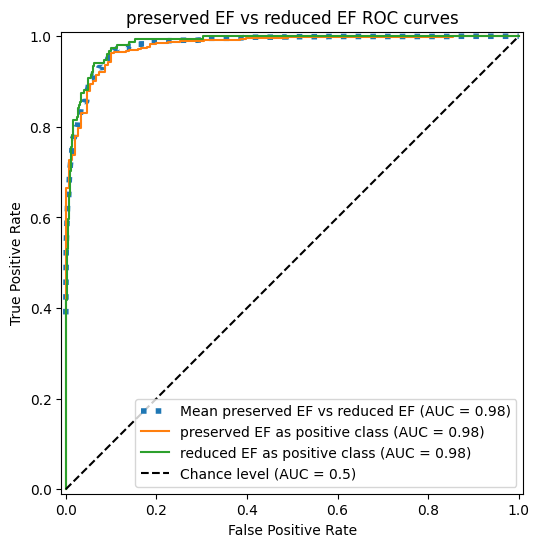

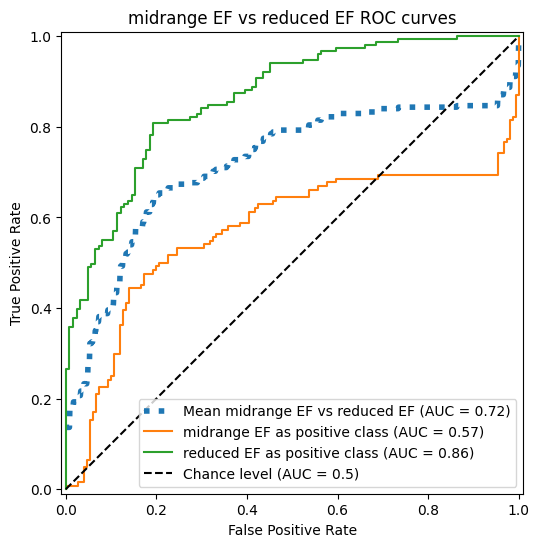

Macro-averaged One-vs-One ROC AUC score:
0.85


In [ ]:
pair_scores = []
mean_tpr = dict()

for ix, (label_a, label_b) in enumerate(pair_list):
    a_mask = y_test == label_a
    b_mask = y_test == label_b
    ab_mask = np.logical_or(a_mask, b_mask)

    a_true = a_mask[ab_mask]
    b_true = b_mask[ab_mask]

    idx_a = np.flatnonzero(label_binarizer.classes_ == label_a)[0]
    idx_b = np.flatnonzero(label_binarizer.classes_ == label_b)[0]

    fpr_a, tpr_a, _ = roc_curve(a_true, y_score[ab_mask, idx_a])
    fpr_b, tpr_b, _ = roc_curve(b_true, y_score[ab_mask, idx_b])

    mean_tpr[ix] = np.zeros_like(fpr_grid)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
    mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
    mean_tpr[ix] /= 2
    mean_score = auc(fpr_grid, mean_tpr[ix])
    pair_scores.append(mean_score)

    fig, ax = plt.subplots(figsize=(6, 6))
    plt.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {target_names[label_a]} vs {target_names[label_b]} (AUC = {mean_score :.2f})",
        linestyle=":",
        linewidth=4,
    )
    RocCurveDisplay.from_predictions(
        a_true,
        y_score[ab_mask, idx_a],
        ax=ax,
        name=f"{target_names[label_a]} as positive class",
    )
    RocCurveDisplay.from_predictions(
        b_true,
        y_score[ab_mask, idx_b],
        ax=ax,
        name=f"{target_names[label_b]} as positive class",
        plot_chance_level=True,
    )
    ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"{target_names[idx_a]} vs {target_names[label_b]} ROC curves",
    )
plt.show()


print(f"Macro-averaged One-vs-One ROC AUC score:\n{np.average(pair_scores):.2f}")

In [ ]:
macro_roc_auc_ovo = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovo",
    average="macro",
)

print(f"Macro-averaged One-vs-One ROC AUC score:\n{macro_roc_auc_ovo:.2f}")

Macro-averaged One-vs-One ROC AUC score:
0.85


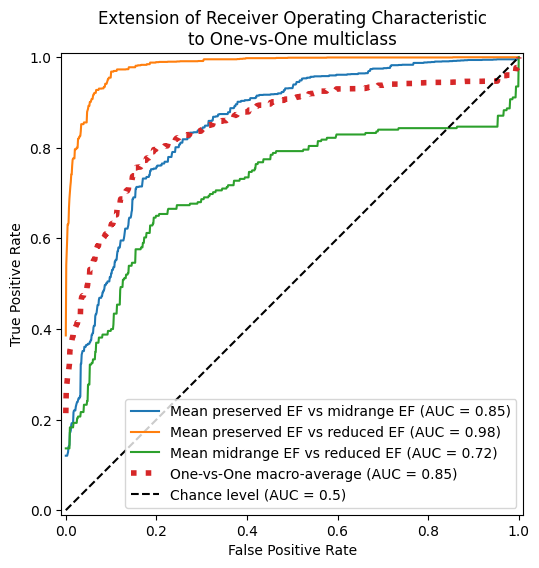

In [ ]:
ovo_tpr = np.zeros_like(fpr_grid)

fig, ax = plt.subplots(figsize=(6, 6))
for ix, (label_a, label_b) in enumerate(pair_list):
    ovo_tpr += mean_tpr[ix]
    ax.plot(
        fpr_grid,
        mean_tpr[ix],
        label=f"Mean {target_names[label_a]} vs {target_names[label_b]} (AUC = {pair_scores[ix]:.2f})",
    )

ovo_tpr /= sum(1 for pair in enumerate(pair_list))

ax.plot(
    fpr_grid,
    ovo_tpr,
    label=f"One-vs-One macro-average (AUC = {macro_roc_auc_ovo:.2f})",
    linestyle=":",
    linewidth=4,
)
ax.plot([0, 1], [0, 1], "k--", label="Chance level (AUC = 0.5)")
ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-One multiclass",
    aspect="equal",
    xlim=(-0.01, 1.01),
    ylim=(-0.01, 1.01),
)
plt.legend()
plt.show()

# Look at misclassified

In [ ]:
ini_array = np.argmax(eclf.predict_proba(X_test), axis = 1)

In [ ]:
unique, frequency = np.unique(ini_array,
                              return_counts = True)
# print unique values array
print("Unique Values:",
      unique)

# print frequency array
print("Frequency Values:",
      frequency)

Unique Values: [0 1 2]
Frequency Values: [944 166 167]


In [ ]:
merged_t['pred_class_3']  = np.where(np.argmax(eclf.predict_proba(X_test), axis=1) == 0, "preserved",\
                                     np.where(np.argmax(eclf.predict_proba(X_test), axis=1) == 1, "midrange", "reduced"))


In [ ]:
merged_t[["label", "true_class"]].value_counts()

,,count
label,true_class,
0,preserved,1002
2,reduced,151
1,midrange,124


In [ ]:
merged_t.pred_class_3.value_counts()

,count
pred_class_3,
preserved,944
reduced,167
midrange,166


[Article](https://pmc.ncbi.nlm.nih.gov/articles/PMC8979576/)

In [ ]:
# major discrepancy between label and prediction in Standford's article
discrepancy_list = ['0X4EFB94EA8F9FC7C2', '0XB3FFC4AE334E9F4', '0X15C0D7DBFF8E4FC8', '0X41AC5C5FC2E3352A',
            '0X211D307253ACBEE7','0X5A8D9673920F03FE','0X75AF130134AADF00','0X6703FCFAD2E7CBCA',
            '0X345D4E0B1B2EBAA1','0X1B2BCDAE290F6015','0X15CC6C50F1763B61','0X7D567F2A870FD8F0',
            '0X2507255D8DC30B4E','0X493E34208D40DBB5','0X56FD0409BFA202DF','0X2D4304FA6A09F93E',
            '0X1EDA0F3F33F97A9D','0X66C8EAE88FFB77EE','0X1EF35FFC92F4F554','0X1CDE7FECA3A1754B',
            '0X777692B30E35465A','0X29E66C557C99EC32','0X31B6E6B67B97806A','0X30DF42C999969D67',
            '0X36715FD73D74BF39','0XAA3E06425E1A23E','0X60361B7F301DEBB7','0X32AFF6A0BED73A67',
            '0X8558D35ED09F890','0X868028466F66DE2','0X41130893A44122AB','0X69447E46FEDD2A3F',
            '0X797CA10A7CDE384B','0XBCEAB22A81A23C1','0X2889D8C33077C148','0X6DFE8F195ACC3BA4',
            '0X62431BB9CF3A33EE','0X27250C8B6DF1D971','0X79DFCFF4867CB797','0X2DF88C27BB20C25D']
len(discrepancy_list)

40

In [ ]:
# incorrect labels by experts review in article
wrong_list = ['0X15C0D7DBFF8E4FC8', '0X41AC5C5FC2E3352A',
            '0X6703FCFAD2E7CBCA',
            '0X345D4E0B1B2EBAA1',
            '0X2507255D8DC30B4E','0X56FD0409BFA202DF',
            '0X1EF35FFC92F4F554','0X1CDE7FECA3A1754B',
            '0X31B6E6B67B97806A',
            '0XAA3E06425E1A23E','0X60361B7F301DEBB7','0X32AFF6A0BED73A67',
            '0X8558D35ED09F890','0X69447E46FEDD2A3F',
            '0X797CA10A7CDE384B',
            '0X62431BB9CF3A33EE','0X2DF88C27BB20C25D']
len(wrong_list)

17

In [ ]:
merged_t_r_as_p = merged_t.query(' pred_class_3 == "preserved" and true_class == "reduced"  ')["video"]

In [ ]:
len(merged_t_r_as_p)

8

In [ ]:
merged_t_p_as_r = merged_t.query(' pred_class_3 == "reduced" and true_class == "preserved"  ')["video"]



In [ ]:
len(merged_t_p_as_r)

16

In [ ]:
ultra_wrong = pd.concat([merged_t_r_as_p, merged_t_p_as_r])

In [ ]:
ultra_wrong = df_tot.merge(ultra_wrong, on = "video")
len(ultra_wrong)

24

In [ ]:
ultra_wrong.describe()

,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Duration
count,24.000000,24.000000,24.000000,24.0,24.0,24.000000,24.000000,24.000000
mean,47.699102,45.381706,88.291050,112.0,112.0,50.333333,145.625000,2.894585
std,11.237373,19.683705,35.692856,0.0,0.0,3.370804,40.146268,0.771604
min,27.931361,16.249747,22.547597,112.0,112.0,40.000000,51.000000,1.020000
25%,37.923228,27.267850,60.316499,112.0,112.0,50.000000,116.500000,2.330000
50%,50.677408,43.686389,87.978290,112.0,112.0,50.000000,154.000000,3.229565
75%,55.873673,62.180132,117.455391,112.0,112.0,50.000000,167.000000,3.375000
max,62.596498,79.599161,147.416123,112.0,112.0,58.000000,224.000000,4.480000


In [ ]:
ultra_wrong["suspicious"]= ultra_wrong["video"].isin(discrepancy_list)

In [ ]:
ultra_wrong.query(' suspicious ') # instances in both

,video,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split,Duration,EFClass,suspicious
0,0X15C0D7DBFF8E4FC8,34.770700,44.479026,68.188722,112,112,58,195,TEST,3.362069,reduced,True
1,0X15CC6C50F1763B61,50.160039,65.549754,131.520475,112,112,50,165,TEST,3.300000,preserved,True
18,0X7D567F2A870FD8F0,29.127013,75.016471,105.846351,112,112,50,137,TEST,2.740000,reduced,True
19,0X868028466F66DE2,56.234366,61.731597,141.050389,112,112,50,187,TEST,3.740000,preserved,True
20,0XB3FFC4AE334E9F4,30.059072,26.764874,38.267828,112,112,50,126,TEST,2.520000,reduced,True


In [ ]:
len(ultra_wrong.query(' suspicious '))

5

In [ ]:
merged_t["incorrect"] = merged_t["video"].isin(wrong_list)

In [ ]:
len(merged_t.query(' incorrect '))

17

In [ ]:
ultra_wrong["incorrect"]= ultra_wrong["video"].isin(wrong_list)

In [ ]:
ultra_wrong.query(' incorrect ')

,video,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split,Duration,EFClass,suspicious,incorrect
0,0X15C0D7DBFF8E4FC8,34.7707,44.479026,68.188722,112,112,58,195,TEST,3.362069,reduced,True,True
